In [1]:
import cartopy as car
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.signal import filtfilt, cheby1, butter, lombscargle, argrelmax, welch, periodogram,  argrelextrema
import pickle
from scipy.stats import pearsonr
import pandas as pd
import netCDF4 as nc
from datetime import date, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
with open('t.pkl', 'rb') as file: # read JJA time series data
    time_series = pickle.load(file)

In [3]:
with open('JJA_average_air_r2.pkl', 'rb') as file:
    JJA_a_air = pickle.load(file)

In [4]:
with open('not_out_index.pkl', 'rb') as file:
    not_out_index = pickle.load(file)

In [5]:
with open('full_average_air_r2.pkl', 'rb') as file:
    full_ave = pickle.load(file)

In [6]:
def cheby_lowpass(cutoff, fs, order, rp):  # to serve the filter
    nyq = 0.5 * fs
    normal_cutoff = cutoff/ nyq
    b, a = cheby1(order, rp, normal_cutoff, btype = "low", analog = False)
    return b, a
'''
scipy.signal.cheby1: Design an Nth-order digital/analog Chebyshev 1 I filter and return the filter coefficients.
fs: the sampling frequency of the digital system.
rp: the max ripple allowed below unity gain in the passband. 
'''


'\nscipy.signal.cheby1: Design an Nth-order digital/analog Chebyshev 1 I filter and return the filter coefficients.\nfs: the sampling frequency of the digital system.\nrp: the max ripple allowed below unity gain in the passband. \n'

In [7]:
def cheby_lowpass_filter(x, cutoff, fs, order, rp):
    b, a = cheby_lowpass(cutoff, fs, order ,rp)
    y = filtfilt(b, a, x)
    return y
'''
filtfilt: Apply a digital filter forward and backward to a signal.
'''

'\nfiltfilt: Apply a digital filter forward and backward to a signal.\n'

In [8]:
def JJA_date_generate(y1, y2):
    """y1 start year, y2 end year and generate the dates for JJA"""
    years = range(y1, y2+1)
    JJA_dates = []
    start = date(y1, 1, 1)
    for y in years:
        now = date(y, 6, 1)
        for n in range(92):
            delta = now - start
            JJA_dates.append(delta.days)
            now += timedelta(days=1)
    return JJA_dates
        


In [9]:
def date_in_month(days):
    '''find what month is that'''
    star = date(1998, 1 ,1)
    now = star + timedelta(days=days)
    return now.strftime("%Y%m%d")

In [10]:
JJA = JJA_date_generate(1998, 2016)
len(JJA)

1748

In [11]:
"""ex = [date_in_month(a) for a in JJA]
False not in [e[-3] for e in ex]"""

'ex = [date_in_month(a) for a in JJA]\nFalse not in [e[-3] for e in ex]'

In [12]:
time_series

{'t': array([[0., 0., 0., ..., 0., 0., 0.]]),
 't12': array([[0., 0., 0., ..., 0., 0., 0.]]),
 't21': array([[0., 0., 0., ..., 0., 0., 0.]])}

In [13]:
BA = time_series['t'][0] + time_series['t21'][0]
len(BA)

6940

In [14]:
# fillter
cutoff = 10
euro_sca = cheby_lowpass_filter(BA, 0.95 * 1. / cutoff, 1, 8, .05)

In [15]:
percen = np.percentile(euro_sca[JJA], 90)
percen

7960.612643732678

In [16]:
local_max_index = argrelextrema(euro_sca, np.greater)[0]
len(local_max_index)

613

In [17]:
#fillter using 90th 
BA_lomax = euro_sca[local_max_index]
bo_lomax = np.array([a > percen for a in BA_lomax])

In [18]:
loc_max_BA = np.vstack((BA_lomax, local_max_index))
print(loc_max_BA.shape)

(2, 613)


In [19]:
BA_pass = []
for n in range(613):
    if bo_lomax[n]:
        BA_pass.append(loc_max_BA[:,n])

In [20]:
print(len(BA_pass))
BA_pass_JJA = [n for n in BA_pass if n[1] in JJA]
print(len(BA_pass_JJA))

58
36


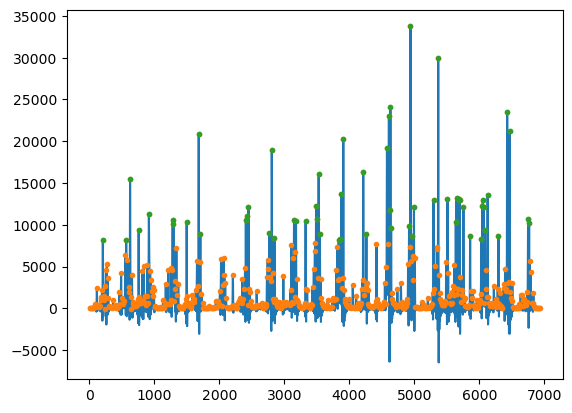

In [21]:
plt.plot(range(6940), euro_sca)
plt.plot(local_max_index, euro_sca[local_max_index], '.')
plt.plot([B[1] for B in BA_pass ], [B[0] for B in BA_pass ], '.')

In [22]:
start = date(1998, 1, 1)
# Date_AB_inter = [(start + timedelta(days=d[1])).strftime("%Y%m%d") for d in AB_pass]
Date_BA_inter = [(start + timedelta(days=d[1])).strftime("%Y%m%d") for d in BA_pass]

In [23]:
air_whole = []
years = [str(n) for n in range(1998,2017)]
for y in years:
    string = 'data/' + 'v_wind_r2_dailymean/'+ 'vwnd.' + y + '.nc'
    nc_da = nc.Dataset(string)
    for a in nc_da['vwnd'][:, 8, :, :]:
        air_whole.append(a)
air_whole = np.array(air_whole)

In [24]:
air_BA_pass_index = [int(n[1]) for n in BA_pass_JJA]
len(air_BA_pass_index)

36

In [25]:
air_BA_pass_index_3 = [a + 3 for a in air_BA_pass_index]

In [26]:
#average before minus
# which is acturally no difference from minus then average
ano_air = np.mean(air_whole[air_BA_pass_index], axis=0)
ano_air.shape
com_air_ano = ano_air - JJA_a_air
com_air_ano.shape
com_air_ano_c = np.clip(com_air_ano, -4, 4)

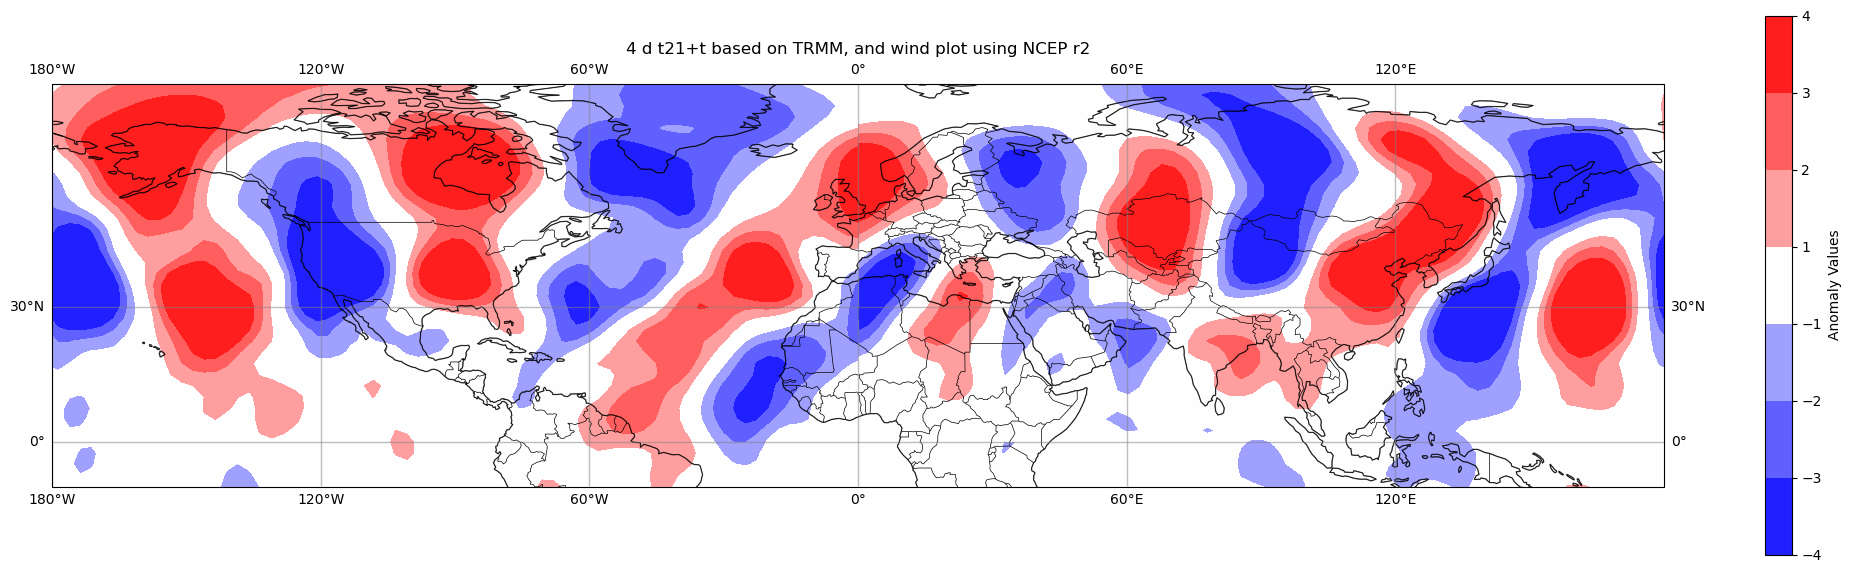

In [27]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-90, 90, 0, 360]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels =  [-4, -3, -2, -1, 1, 2, 3, 4] # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(0,360 ,144),np.linspace(-90,90,73), com_air_ano_c, cmap='bwr', transform=ccrs.PlateCarree(), levels = levels)
plt.ylim([-10,80])
#contour.cmap.set_under('white')
# Add a colorbar
cbar = cbar = plt.colorbar(contour,  shrink=0.7)
# cbar = cbar = plt.colorbar(contour, ticks=[-4, -3, -2, -1, 1, 2, 3, 4], shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('4 d t21+t based on TRMM, and wind plot using NCEP r2')
plt.savefig('com_ano_useTRMM')
plt.show()

In [28]:
#average before minus
# which is acturally no difference from minus then average
ano_air = np.mean(air_whole[air_BA_pass_index_3], axis=0)
ano_air.shape
com_air_ano = ano_air - JJA_a_air
com_air_ano.shape
com_air_ano_c = np.clip(com_air_ano, -4, 4)

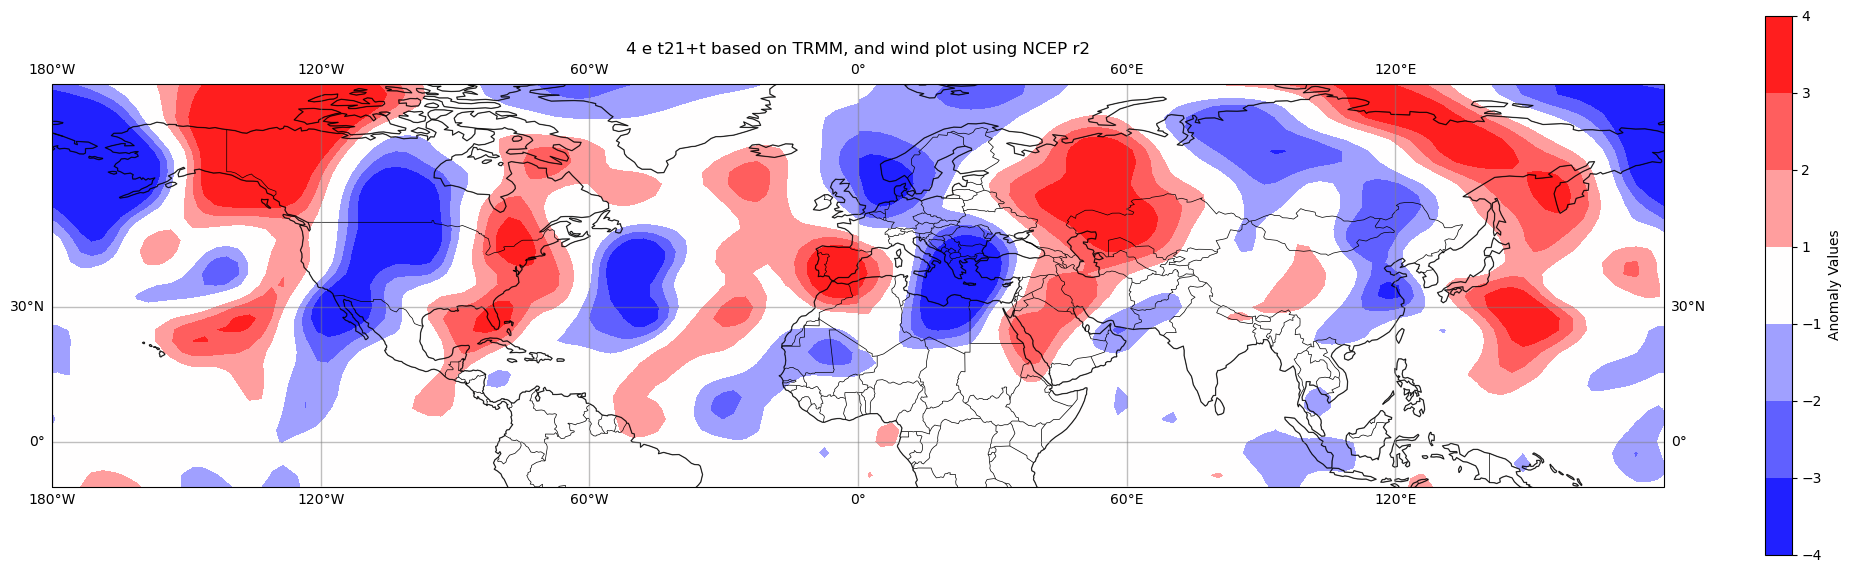

In [29]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-90, 90, 0, 360]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels =  [-4, -3, -2, -1, 1, 2, 3, 4] # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(0,360 ,144),np.linspace(-90,90,73), com_air_ano_c, cmap='bwr', transform=ccrs.PlateCarree(), levels = levels)
plt.ylim([-10,80])
#contour.cmap.set_under('white')
# Add a colorbar
cbar = cbar = plt.colorbar(contour,  shrink=0.7)
# cbar = cbar = plt.colorbar(contour, ticks=[-4, -3, -2, -1, 1, 2, 3, 4], shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('4 e t21+t based on TRMM, and wind plot using NCEP r2')

plt.savefig('com_ano_useTRMM_3')
plt.show()

In [394]:
# use full year average instead
ano_air = np.mean(air_whole[air_BA_pass_index], axis=0)
ano_air.shape
com_air_ano = ano_air - full_ave
com_air_ano.shape
com_air_ano_c = np.clip(com_air_ano, -4, 4)

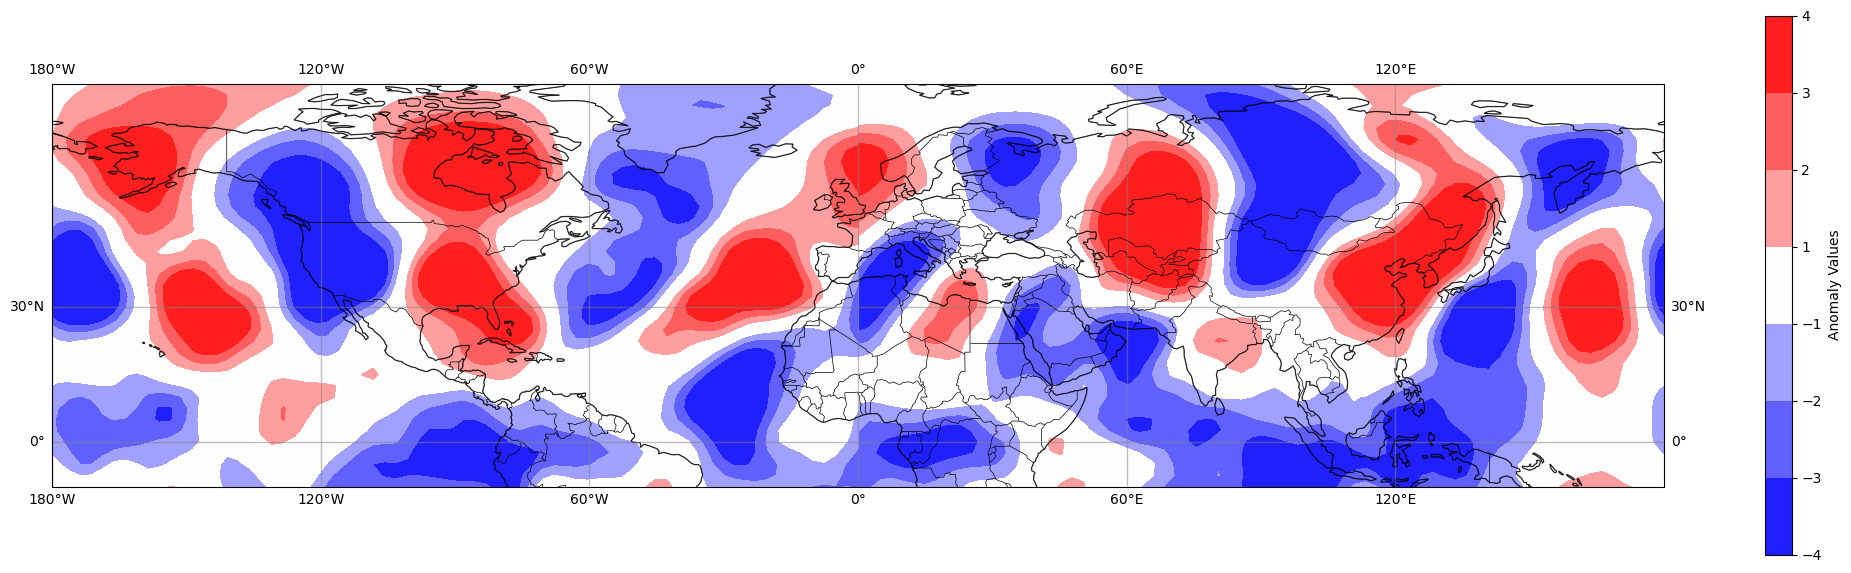

In [395]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-90, 90, 0, 360]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels =  [-4, -3, -2, -1, 1, 2, 3, 4] # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(0,360 ,144),np.linspace(-90,90,73), com_air_ano_c, cmap='bwr', transform=ccrs.PlateCarree(), levels = levels)
plt.ylim([-10,80])
#contour.cmap.set_under('white')
# Add a colorbar
cbar = cbar = plt.colorbar(contour,  shrink=0.7)
# cbar = cbar = plt.colorbar(contour, ticks=[-4, -3, -2, -1, 1, 2, 3, 4], shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


plt.show()

In [396]:
air_whole[air_BA_pass_index].shape

(36, 73, 144)

In [397]:
BA_hanson = [ 207,566, 626, 758, 915, 1281, 1293,1497, 1682, 1707, 2407, 2419, 2448 ,2767, 2806, 2848, 3149, 3179 ,3327, 3488 ,3505, 3528, 3547, 3836, 3864, 3876, 3907, 4214 ,4263 ,4579, 4609, 4620, 4632, 4643, 4919, 4941, 4963, 4994, 5296, 5368, 5510, 5638, 5650, 5687, 5698, 5756, 5859, 6031, 6045, 6053, 6066, 6086 ,6128, 6295, 6429, 6465, 6751, 6767]


In [398]:
BA_pass_arra = np.array([a[1] for a in BA_pass])
BA_hanson_arra = np.array(BA_hanson)


In [399]:
BA_pass_arra

array([ 207.,  566.,  626.,  758.,  915., 1281., 1293., 1497., 1682.,
       1707., 2407., 2419., 2448., 2767., 2806., 2848., 3149., 3179.,
       3327., 3488., 3505., 3528., 3547., 3836., 3864., 3876., 3907.,
       4214., 4263., 4579., 4609., 4620., 4632., 4643., 4919., 4941.,
       4963., 4994., 5296., 5368., 5510., 5638., 5650., 5687., 5698.,
       5756., 5859., 6031., 6045., 6053., 6066., 6086., 6128., 6295.,
       6429., 6465., 6751., 6767.])

In [400]:
print(len(BA_hanson_arra))
print(len(BA_pass_arra))

58
58


In [401]:
def are_arrays_equal(arr1, arr2):
    # Step 1: Check lengths
    if len(arr1) != len(arr2):
        return False
    
    # Step 3: Compare elements
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            return False
    
    return True

In [402]:
are_arrays_equal(BA_hanson_arra, BA_pass_arra)

True

In [403]:
(date(2014,12,31) - date(1998,1,1)).days

6208

In [404]:
BA_pass_2014 = [n for n in BA_pass_arra if n <= 6208]
len(BA_pass_2014)

53

In [405]:
# look at the individual maxima
sort = sorted(BA_pass_arra, reverse=True)
max_6 = sort[:6]
max_6_in = [list(BA_pass_arra).index(a) for a in max_6]
max_6_in

[57, 56, 55, 54, 53, 52]

In [406]:
# do it on ESBA directly
per_raw = np.percentile(BA[JJA], 99)
per_raw

37966.909999999996

In [407]:
index = np.where(BA > per_raw)[0]
index_JJA = [i for i in index if i in JJA]
print(len(index_JJA))

18


In [408]:
air_whole[index_JJA].shape

(18, 73, 144)

In [409]:
ano_BA = np.mean(air_whole[index_JJA], axis=0)
ano_BA = ano_BA - JJA_a_air

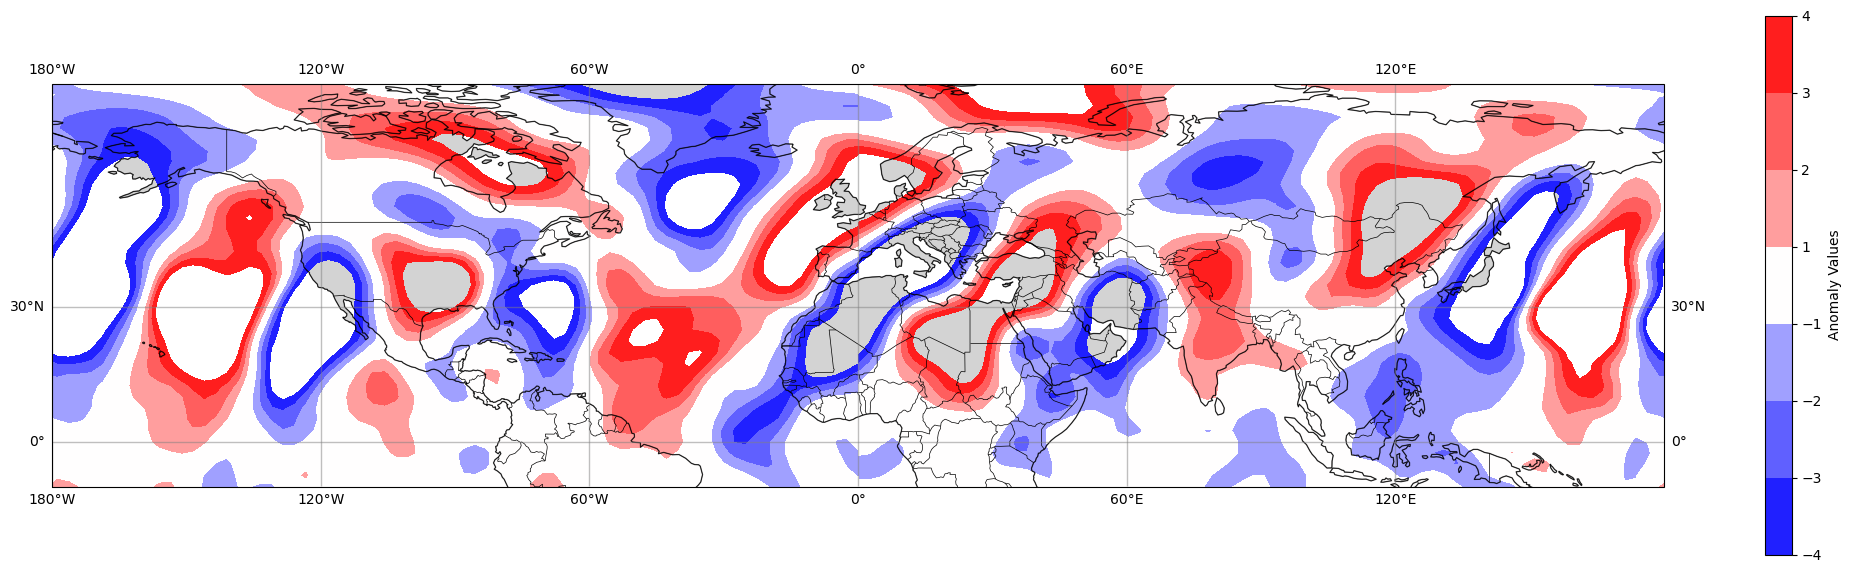

In [410]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-90, 90, -360, 0]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels =  [-4, -3, -2, -1, 1, 2, 3, 4] # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(0,360 ,144),np.linspace(-90,90,73), ano_BA, cmap='bwr', transform=ccrs.PlateCarree(), levels = levels)
plt.ylim([-10,80])
#contour.cmap.set_under('white')
# Add a colorbar
cbar = cbar = plt.colorbar(contour,  shrink=0.7)
# cbar = cbar = plt.colorbar(contour, ticks=[-4, -3, -2, -1, 1, 2, 3, 4], shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


plt.show()

In [411]:
air_whole_r1 = []
years = [str(n) for n in range(1998,2017)]
for y in years:
    string = 'data/' + 'v_wind_r1/'+ 'vwnd.' + y + '.nc'
    nc_da = nc.Dataset(string)
    for a in nc_da['vwnd'][:, 8, :, :]:
        air_whole_r1.append(a)
air_whole_r1 = np.array(air_whole_r1)

In [412]:
#average before minus
# which is acturally no difference from minus then average
ano_air = np.mean(air_whole_r1[air_BA_pass_index], axis=0)
com_air_ano = ano_air - JJA_a_air
com_air_ano_c = np.clip(com_air_ano, -4, 4)

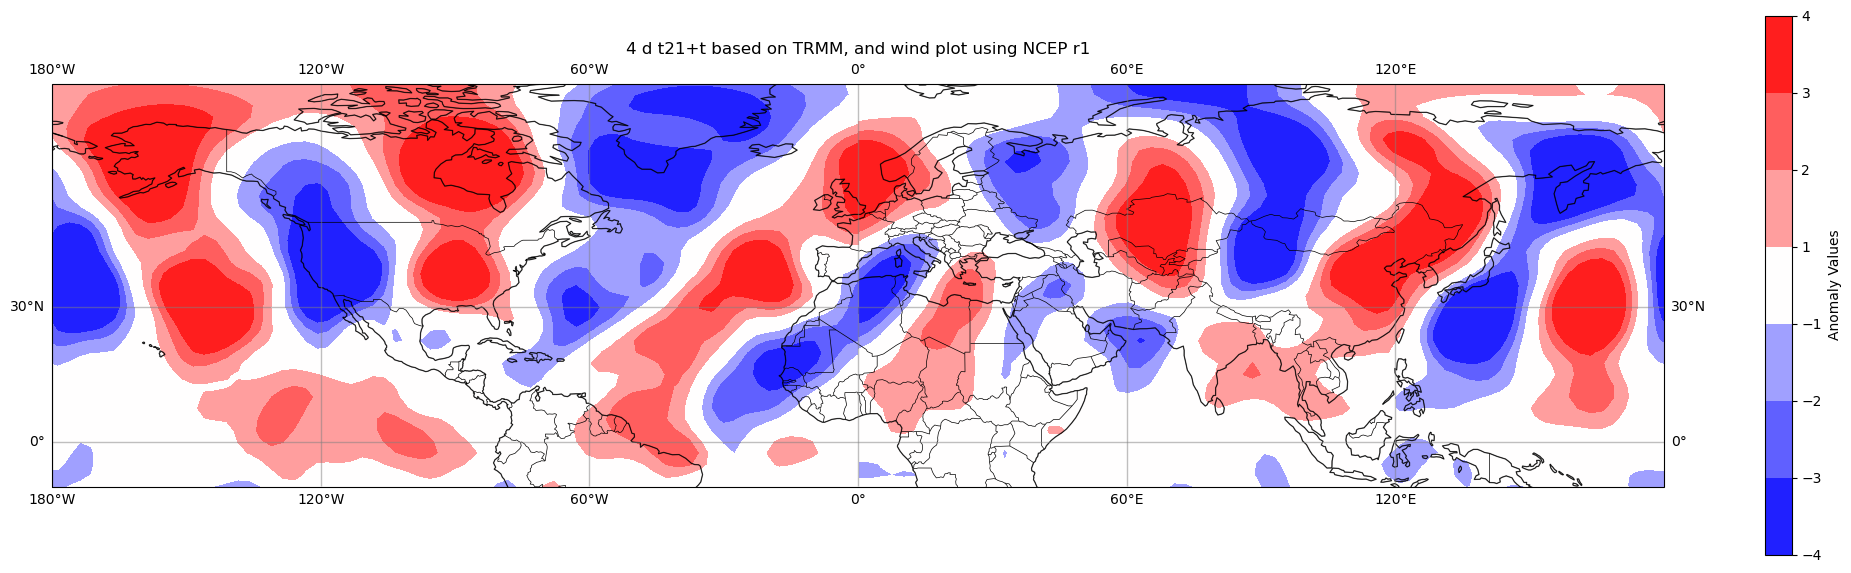

In [413]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-90, 90, 0, 360]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels =  [-4, -3, -2, -1, 1, 2, 3, 4] # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(0,360 ,144),np.linspace(-90,90,73), com_air_ano_c, cmap='bwr', transform=ccrs.PlateCarree(), levels = levels)
plt.ylim([-10,80])
#contour.cmap.set_under('white')
# Add a colorbar
cbar = cbar = plt.colorbar(contour,  shrink=0.7)
# cbar = cbar = plt.colorbar(contour, ticks=[-4, -3, -2, -1, 1, 2, 3, 4], shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('4 d t21+t based on TRMM, and wind plot using NCEP r1')
plt.savefig('com_ano_useTRMM_r1')
plt.show()

In [414]:
ano_air = np.mean(air_whole_r1[air_BA_pass_index_3], axis=0)
com_air_ano = ano_air - JJA_a_air
com_air_ano_c = np.clip(com_air_ano, -4, 4)

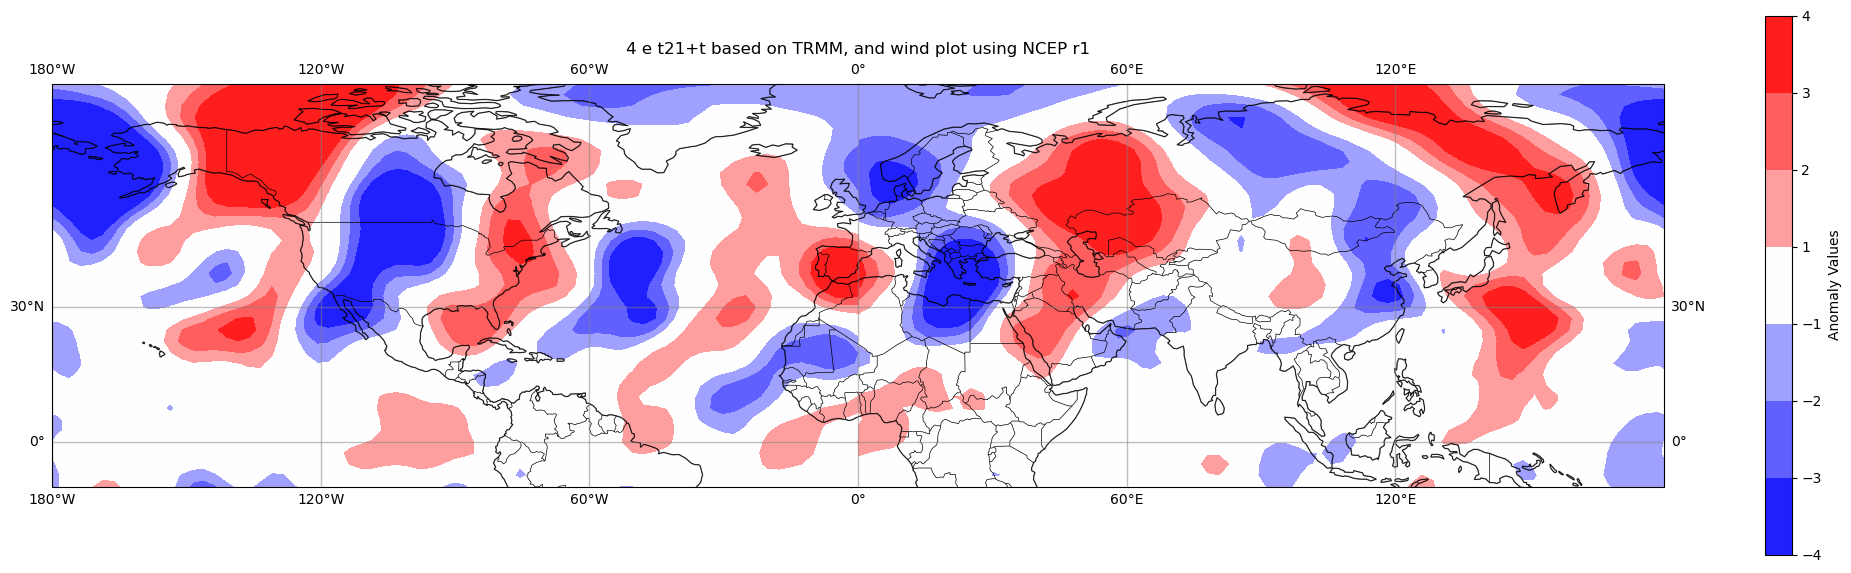

In [415]:
# Assuming you have defined the variables: com_anomalies, extent

# Define the figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(26, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the world map
extent = [-90, 90, 0, 360]
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the filled contour plot on the map
levels =  [-4, -3, -2, -1, 1, 2, 3, 4] # Define contour levels from -6 to 6 with 13 levels
contour = ax.contourf(np.linspace(0,360 ,144),np.linspace(-90,90,73), com_air_ano_c, cmap='bwr', transform=ccrs.PlateCarree(), levels = levels)
plt.ylim([-10,80])
#contour.cmap.set_under('white')
# Add a colorbar
cbar = cbar = plt.colorbar(contour,  shrink=0.7)
# cbar = cbar = plt.colorbar(contour, ticks=[-4, -3, -2, -1, 1, 2, 3, 4], shrink=0.7)
cbar.set_label('Anomaly Values')

# Add grid
# Add coastlines
ax.coastlines(alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5)
gl.xlocator = mticker.FixedLocator([n for n in range(-180, 180, 60)])
gl.ylocator = mticker.FixedLocator([-30, 0, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title('4 e t21+t based on TRMM, and wind plot using NCEP r1')
plt.savefig('com_ano_useTRMM_r1_3')
plt.show()